In [2]:
# This notebook is the intial modeling efforts for the Instrument Recognition problem.
# Group 1: Thomas Stapor, Abhijith Gururaj, Akhil Palla

# Libraries needed for data processing.
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [7]:
# Constants for Librosa to load in the audio files
frameSize = 2048
hopSize = 512

In [56]:
# list and dictionary of instruments present and corresponding index positions
instruments = ['cel','cla','flu','gac','gel','org','pia','sax','tru','vio','voi']
instrument_labels = {'cel':1,'cla':2,'flu':3,'gac':4,'gel':5,'org':6,'pia':7, 'sax': 8, 'tru' :9, 'vio': 10, 'voi':11}

# Traing data path, must be edited if reproducing results
training_data_path = 'c:/Users/thoma/Documents/Virginia Tech/CS5806/Project/IRMAS-TrainingData/IRMAS-TrainingData/'

data = []
labels = []

# For each instrument present, loop over each file and generate a spectrogram and save it as an image array.
for instrument in instruments:
    path = training_data_path + instrument
    file_names = os.listdir(path)
    for file in file_names:

        # Cleaning up the path
        current_audio_file = path + '/' + file
        instrument_name = file.split('[')[1][:-1]
        # Load file into Librosa
        audio, sample_rate = librosa.load(current_audio_file)

        # Generate the spectrogram and save it locally
        y_stft = np.abs(librosa.stft(audio, win_length=frameSize, hop_length=hopSize,
        center=True))
        M = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        M_db = librosa.power_to_db(M, ref=np.max)
        spec = librosa.display.specshow(M_db, sr = sample_rate, hop_length = hopSize, y_axis='mel', x_axis='time')
        plt.savefig("C:/Users/thoma/Documents/Virginia Tech/CS5806/Project/images/" + instrument +'_' + file + '.png', transparent=True)
        plt.close()
        
        # Read the spectrogram image file, greyscale it to save computation space, and append the pixel array to use later
        img = cv2.imread("C:/Users/thoma/Documents/Virginia Tech/CS5806/Project/images/" + instrument +'_' + file + '.png')
        grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        data.append(grey_img.flatten())
        labels.append(instrument_labels[instrument_name] - 1)
      



In [57]:
# Type fixing and one-hot-encoding of the insturment labels
data = np.array(data)
labels = np.array(labels).reshape(data.shape[0], 1)
labels_nn = np.zeros((labels.shape[0], 11))
for i in range(labels.shape[0]):
    labels_nn[i][labels[i]] = 1

In [9]:
# getting testing files
test_path = 'C:/Users/thoma/Documents/Virginia Tech/CS5806/Project/IRMAS-TestingData-Part1/IRMAS-TestingData-Part1/Part1/'
test_files = os.listdir(test_path)

test_data = []
test_labels = []

for test_file in test_files:
    # Test labels are stored in text file and need to be handled differently.
    if 'txt' in test_file:
        f = open(test_path + test_file, 'r')
        labels = f.readlines()
        f.close()

        labels = [word.replace('\t\n','') for word in labels]
        if 'voi' in labels:
            test_labels.append(1)
        else:
            test_labels.append(0)
    else:
        # Same process as training data above.
        current_audio_file = test_path + test_file

        audio, sample_rate = librosa.load(current_audio_file)

        y_stft = np.abs(librosa.stft(audio, win_length=frameSize, hop_length=hopSize,center=True))

        M = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        M_db = librosa.power_to_db(M, ref=np.max)

        spec = librosa.display.specshow(M_db, sr = sample_rate, hop_length = hopSize, y_axis='mel', x_axis='time')
        plt.savefig("C:/Users/thoma/Documents/Virginia Tech/CS5806/Project/images_testing/" + test_file + '.png', transparent=True)
        plt.close()
        
        img = cv2.imread("C:/Users/thoma/Documents/Virginia Tech/CS5806/Project/images_testing/" + test_file + '.png')
        grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        test_data.append(grey_img.flatten())

In [14]:
# Type fixing
test_data = np.array(test_data)
test_labels = np.array(test_labels).reshape(test_data.shape[0], 1)

In [13]:
# creating labels for voice detection experiment
labels_voi = np.zeros((labels.shape[0],2))
for i in range(labels.shape[0]):
    if labels_nn[i][instrument_labels['voi'] - 1] == 1:
        labels_voi[i][0] = 1

In [16]:
# creating labels for voice detection experiment
labels_test_voi = np.zeros((test_labels.shape[0],2))
for i in range(test_labels.shape[0]):
    if test_labels[i] == 1:
        labels_test_voi[i][0] = 1

array([[0., 0.],
       [0., 0.],
       [1., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [59]:
# creating labels for instrument family detection experiment
labels_groups = np.zeros((labels.shape[0],5))
# strings 0, wind 1, piano 2, brass 3, voice 4 

for i in range(labels.shape[0]):
    if labels_nn[i][instrument_labels['cel']-1] == 1 or labels_nn[i][instrument_labels['gac']-1] == 1 or labels_nn[i][instrument_labels['gel']-1] == 1 or labels_nn[i][instrument_labels['vio']-1] == 1:
        labels_groups[i][0] = 1
    elif labels_nn[i][instrument_labels['cla']-1] == 1 or labels_nn[i][instrument_labels['flu']-1] == 1 or labels_nn[i][instrument_labels['org']-1] == 1:
        labels_groups[i][1] = 1
    elif labels_nn[i][instrument_labels['pia']-1] == 1:
        labels_groups[i][2] = 1
    elif labels_nn[i][instrument_labels['tru']-1] == 1 or labels_nn[i][instrument_labels['sax']-1] == 1:
        labels_groups[i][3] = 1
    else:
        labels_groups[i][4] = 1

In [10]:
# Libraries needed for simple neural network modeling
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import History
from keras.optimizers import Adam

In [75]:
# Peform test, train, and validation split on data. Note: repalce 'labels_groups' with labels choice to change what experiment is being run.
# For example, potting labels_voi will change the data spilt to run the voice detection experiment.
# Will also need to change the size of the neural network output layer.
x_train, x_test, y_train, y_test = train_test_split(data, labels_groups, test_size=0.15, random_state=0)
x_train, x_val, y_train, y_val  = train_test_split(x_train, y_train, test_size=0.15, random_state=0)

# Build simple neural network and train it. Default experiment is the instrument family labeling.
model = tf.keras.models.Sequential()
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
instrument_model = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
152/152 [==============================] - 18s 115ms/step - loss: 363.1053 - accuracy: 0.2663 - val_loss: 114.7352 - val_accuracy: 0.3240
Epoch 2/10
152/152 [==============================] - 17s 113ms/step - loss: 64.0512 - accuracy: 0.2203 - val_loss: 34.6395 - val_accuracy: 0.3041
Epoch 3/10
152/152 [==============================] - 17s 114ms/step - loss: 42.7011 - accuracy: 0.2552 - val_loss: 25.3625 - val_accuracy: 0.2865
Epoch 4/10
152/152 [==============================] - 17s 111ms/step - loss: 41.4166 - accuracy: 0.2717 - val_loss: 19.2905 - val_accuracy: 0.2012
Epoch 5/10
152/152 [==============================] - 16s 106ms/step - loss: 18.7359 - accuracy: 0.2764 - val_loss: 9.8892 - val_accuracy: 0.3029
Epoch 6/10
152/152 [==============================] - 17s 113ms/step - loss: 22.8344 - accuracy: 0.2706 - val_loss: 13.0387 - val_accuracy: 0.3614
Epoch 7/10
152/152 [==============================] - 16s 106ms/step - loss: 14.4397 - accuracy: 0.3074 - val_loss: 3

In [76]:
loss, accuracy = model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 14ms/step - loss: 15.4606 - accuracy: 0.2465


32/32 [==============================] - 0s 14ms/step


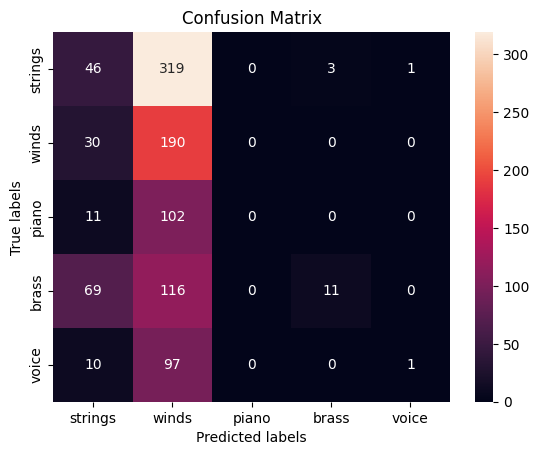

In [77]:
# Confusion matrix generation for instrument family experiment
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

group_labels=['strings','winds','piano','brass','voice']

mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(group_labels); ax.yaxis.set_ticklabels(group_labels);

In [52]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                19660864  
                                                                 
 activation_36 (Activation)  (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 activation_37 (Activation)  (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 16)                528       
                                                                 
 activation_38 (Activation)  (None, 16)                0         
                                                                 
 dense_39 (Dense)            (None, 4)                

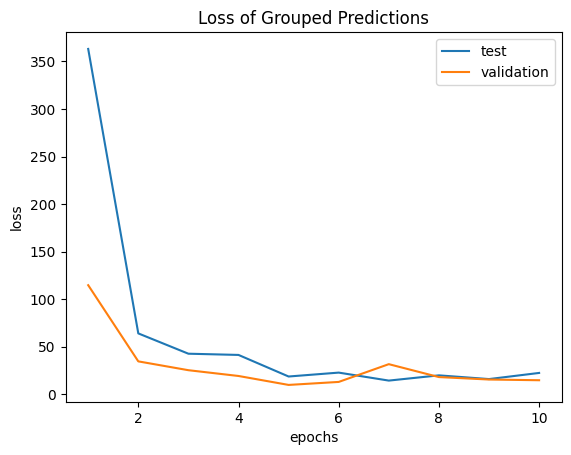

In [78]:
# Loss of most recently run experiment.
loss = instrument_model.history['loss']
val_loss = instrument_model.history['val_loss']

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='test')
plt.plot(epochs, val_loss, label='validation')
plt.title('Loss of Grouped Predictions')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()